In [1]:
import os
import json
import time
import click
import veritas
import numpy as np
import pandas as pd

import prada
import model_params
import util
import tree_compress

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

sns.set_context('notebook', font_scale=1.15)
sns.set_style("whitegrid", {
    "grid.color": (0.9, 0.9, 0.9),
    "grid.linestyle": ":",
    'axes.edgecolor': 'black',
    'xtick.bottom': True,
    'xtick.top': False,
    'ytick.left': True,
    'ytick.right': False
})
sns.axes_style("ticks")

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": 12,
    'legend.fontsize': 9,
})

#%matplotlib widget

### DONT FORGET TO PULL THE RESULTS!
# ./get_results.sh
# python experiment.py process_compress results/subsub_all2.txt results/subsub_all3.txt results/subsub_xgbl1.txt results/subsub_ic.txt
# we dropped subsub_all.txt because himec05 is slow

In [2]:
model_type = "xgb"
linclf_type = "Lasso"
seed = util.SEED

In [3]:
key = util.get_key(model_type, linclf_type, seed)
all_train_results = util.load_train_results()[key]
all_compr_results = util.load_compress_results()[key]

In [13]:
colors = plt.get_cmap("tab10").colors

methods = ["xgb", "xgbl1", "ic", "gr", "lrl1", "ours"]
columns = ["mtrain", "mvalid", "mtest", "time", "nleafs"]
mcols = pd.MultiIndex.from_product([methods, columns], names=['method', 'value'])


def get_df(dname):
    train_results = all_train_results[dname]
    compr_results = all_compr_results[dname]

    param_hashes = train_results.keys() & compr_results.keys()
    df = pd.DataFrame(index=list(param_hashes), columns=mcols)

    for params_hash in param_hashes:
        #print(compr_results[params_hash].keys())
        folds = {
            "xgb": train_results[params_hash],
            #"l1": compr_results[params_hash]["l1prune"],
            "xgbl1": compr_results[params_hash]["xgbl1_005"],
            "ic": compr_results[params_hash]["can_ic_005"],
            "gr": compr_results[params_hash]["can_gr_005"],
            "lrl1": compr_results[params_hash]["can_lrl1_005"],
            "ours": compr_results[params_hash]["compress005"],
        }

        #print(folds["ic"][0].keys())

        #foldis = [4]
        for method, v in folds.items():
            foldis = v.keys()
            for m in ["mtrain", "mvalid", "mtest", "nleafs"]:
               df.loc[params_hash, (method, m)] = np.mean([v[k][m] for k in foldis])

            timekey = "train_time" if method == "xgb" else "compr_time"
            df.loc[params_hash, (method, "time")] = np.mean([v[k][timekey] for k in foldis])
        

    df.index = [h[:6] for h in param_hashes]
    return df

def analyze_hull(df):
    allxs, allys, allcs, allms = [], [], [], []
    for mi, method in enumerate(methods):
        allxs += list(df.loc[:, (method, "nleafs")] + 1)
        allys += list(df.loc[:, (method, "mtest")])
        allcs += [colors[mi]] * df.shape[0]
        allms += [method] * df.shape[0]

    perm = np.argsort(allxs)
    allxs = [allxs[i] for i in perm]
    allys = [allys[i] for i in perm]
    allcs = [allcs[i] for i in perm]
    allms = [allms[i] for i in perm]

    onfront, onhull = util.pareto_front_xy(np.array(allxs), np.array(allys))
    frontxs, frontys = zip(*[(allxs[i], allys[i]) for i, b in enumerate(onhull) if b])
    frontcs, frontms = zip(*[(allcs[i], allms[i]) for i, b in enumerate(onhull) if b])
    
    return allxs, allys, allcs, allms, frontxs, frontys, frontcs, frontms

def plot_curve(ax, allxs, allys, allcs, allms, frontxs, frontys, frontcs, frontms):
    #ax.scatter(allxs, allys, c=allcs, marker=".", s=15, alpha=0.5)
    #ax.plot(frontxs, frontys, color="gray", ls=":")
    #ax.scatter(frontxs, frontys, c=frontcs, marker="o", s=30)
    ax.set_xscale("log")
    ax.set_xlabel("Number of leaves")
    ax.set_ylabel("Balanced accuracy")

    onfront, onhull = util.pareto_front_xy(np.array(allxs), np.array(allys))

    sns.scatterplot(x=allxs, y=allys,
                    hue=allms,
                    size=onhull,
                    style=allms,
                    sizes={0: 20, 1: 50},
                    hue_order=methods,
                    style_order=methods,
                    legend="brief",
                    ax=ax)
    ax.plot(frontxs, frontys, color="gray", ls="-", zorder=-1)
    #sns.scatterplot(x=frontxs, y=frontys, hue=frontms, ax=ax)

    #custom_lines = [Line2D([0], [0], ls="", marker=".", color=c, lw=1, ms=8) for c in colors[:len(keys)]]
    #ax.legend(custom_lines, keys, frameon=False)

    xgbxs = np.array(allxs)[[m == "xgb" for m in allms]]
    xgbys = np.array(allys)[[m == "xgb" for m in allms]]
    onfront, onhull = util.pareto_front_xy(xgbxs, xgbys)
    ax.plot(xgbxs[onhull], xgbys[onhull], color="gray", ls=":", zorder=-1)

    legend = ax.get_legend()
    ax.legend(legend.legend_handles[0:len(methods)], methods)

dfs = {}
hullcounts = pd.DataFrame(0, columns=["count", "wins"], index=methods, dtype=int)

In [15]:
for dname in all_compr_results.keys():
    print(dname)
    try:
        df = get_df(dname)
    except KeyError as e:
        print(dname, "KeyError", e)
        continue

    dfs[dname] = df

    #with pd.option_context('display.precision', 3, 'display.max_columns', 100):
    #    display(df)
        #display(df.loc[:, (slice(None), "mtest")])
        #display(df.loc[:, (slice(None), "nleafs")])
    
    allxs, allys, allcs, allms, frontxs, frontys, frontcs, frontms = analyze_hull(df)

    uniq, uniq_cnt = np.unique(frontms, return_counts=True)
    for method, count in zip(uniq, uniq_cnt):
        print(f"  - {method:10} {count}")
        hullcounts.loc[method, "count"] += count
    hullcounts.loc[uniq[np.argmax(uniq_cnt)], "wins"] += 1
    
    #fig, ax = plt.subplots()
    #plot_curve(ax, allxs, allys, allcs, allms, frontxs, frontys, frontcs, frontms)
    
    #if dname == "California":
    #    ax.get_figure().savefig("california.png")

    
    plt.show()

display(hullcounts)

CompasTwoYears
  - lrl1       2
  - ours       1
  - xgb        1
  - xgbl1      1
Vehicle
  - gr         1
  - ic         1
  - lrl1       4
  - ours       1
Spambase
  - gr         1
  - lrl1       2
  - ours       4
Phoneme
  - gr         2
  - ic         2
  - ours       4
  - xgb        1
Nomao
  - gr         3
  - ours       6
  - xgb        2
Adult
  - gr         4
  - ic         1
  - xgbl1      2
Ijcnn1
  - gr         3
  - ours       5
Mnist[2v4]
  - gr         1
  - ic         1
  - lrl1       3
  - ours       6
DryBean[6vRest]
  - gr         4
  - ours       3
Volkert[2v7]
  - ic         2
  - lrl1       1
  - ours       5
  - xgb        4
Credit
  - gr         1
  - ours       3
  - xgb        1
California
  - gr         2
  - ours       7
  - xgb        1
  - xgbl1      1
MiniBooNE
  - gr         5
  - ours       6
Electricity
  - gr         1
  - ic         1
  - ours       10
  - xgb        1
  - xgbl1      2
Jannis
  - gr         1
  - ic         1
  - ours       8
  -

,count,wins
xgb,12,0
xgbl1,6,0
ic,9,0
gr,29,2
lrl1,12,2
ours,69,11


# across all datasets, how many on frontier / wins

In [6]:
display(hullcounts)

,count,wins
xgb,12,0
xgbl1,6,0
ic,9,0
gr,29,2
lrl1,12,2
ours,69,11


In [7]:
dfperf = pd.DataFrame(index=dfs.keys(), columns=pd.MultiIndex.from_product([["nleafs", "mtest"], methods]))

for dname, df in dfs.items():
    relsize = (1.0/df.loc[:, (slice(None), "nleafs")]).multiply(df.loc[:, ("xgb", "nleafs")], axis=0).mean(axis=0)
    relsize.iloc[0] = df.loc[:, ("xgb", "nleafs")].mean()
    relsize.index = relsize.index.get_level_values(0)
    relsize.name = "nleafs"
    relmtest = 100*df.loc[:, (slice(None), "mtest")].subtract(df.loc[:, ("xgb", "mtest")], axis=0).mean(axis=0)
    relmtest.iloc[0] = 100*df.loc[:, ("xgb", "mtest")].mean()
    relmtest.index = relmtest.index.get_level_values(0)
    relmtest.name = "mtest"

    dfperf.loc[dname, ("nleafs", slice(None))] = relsize.values
    dfperf.loc[dname, ("mtest", slice(None))] = relmtest.values
    
with pd.option_context('display.precision', 1, 'display.max_columns', 100):
    dfperf_avg = dfperf.mean(axis=0)
    dfperf_avg_nleafs = dfperf_avg.loc[("nleafs", slice(None))]
    dfperf_avg_nleafs.name = "nleafs"
    dfperf_avg_mtest = dfperf_avg.loc[("mtest", slice(None))]
    dfperf_avg_mtest.name = "mtest"
    dfperf.loc["Avg.", :] = dfperf_avg
    display(dfperf)
    display(dfperf_avg.loc[ ("nleafs", slice(None))])
    display(pd.concat([hullcounts, dfperf_avg_nleafs, dfperf_avg_mtest], axis=1))

nleafs                            mtest                       \
                    xgb xgbl1   ic   gr lrl1  ours   xgb xgbl1   ic   gr lrl1   
CompasTwoYears    289.2   2.6  1.2  1.4  2.2   5.1  67.2  -0.1 -0.1 -0.3 -0.5   
Vehicle           453.3   1.3  1.5  1.2  1.2   3.0  93.7  -0.8 -0.6 -0.2  0.5   
Spambase         1120.3   1.5  1.1  1.3  1.4   7.9  92.7  -0.3 -0.1  0.2  0.4   
Phoneme          2138.3   1.2  1.2  1.2  1.1   4.9  83.2  -0.0 -0.1  0.5  0.1   
Nomao            3386.7   1.6  1.0  1.3  1.3   8.5  94.5  -0.3 -0.0  0.1 -0.4   
Adult            1954.8   3.0  1.2  1.5  1.3   3.3  76.3  -0.0  0.1  1.2 -0.9   
Ijcnn1           4162.1   1.3  1.0  1.2  1.1   3.1  91.5  -0.2 -0.0  1.1 -0.0   
Mnist[2v4]        321.0   1.4  1.1  1.3  1.6   4.4  97.9  -0.3  0.0 -0.1  0.1   
DryBean[6vRest]  1866.1   2.0  1.2  1.6  1.2  43.2  90.9  -0.3 -0.0  0.7 -0.1   
Volkert[2v7]     1973.2   2.4  1.1  1.4  2.0  18.0  98.3  -0.3 -0.0 -0.1 -0.3   
Credit            546.4   1.5  1.1  1.2  1.5   3.2  77.2  -0.3 -0.1 -0.2 -0.5   
California       2664.2   1.2  1.0  1.3  1.3   5.9  88.8  -0.0 -0.0  0.0 -0.2   
MiniBooNE        3171.6   1.5  1.0  1.4  1.3   5.1  92.1  -0.1 -0.0  0.2 -0.3   
Electricity      3969.6   1.2  1.0  1.1  1.1   2.9  86.1  -0.1 -0.0  0.1 -0.2   
Jannis           3157.1   1.4  1.1  1.2  1.2   2.7  77.1  -0.3 -0.0 -0.1 -0.9   
Avg.             2078.3   1.7  1.1  1.3  1.4   8.1  87.2  -0.2 -0.1  0.2 -0.2   

                      
                ours  
CompasTwoYears  -0.4  
Vehicle         -1.5  
Spambase        -0.5  
Phoneme         -0.3  
Nomao           -0.4  
Adult           -0.1  
Ijcnn1          -0.0  
Mnist[2v4]      -0.5  
DryBean[6vRest]  0.1  
Volkert[2v7]    -0.5  
Credit          -0.4  
California      -0.4  
MiniBooNE       -0.4  
Electricity     -0.3  
Jannis          -0.4  
Avg.            -0.4

xgb      2078.3
xgbl1       1.7
ic          1.1
gr          1.3
lrl1        1.4
ours        8.1
dtype: object

,count,wins,nleafs,mtest
xgb,12,0,2078.3,87.2
xgbl1,6,0,1.7,-0.2
ic,9,0,1.1,-0.1
gr,29,2,1.3,0.2
lrl1,12,2,1.4,-0.2
ours,69,11,8.1,-0.4


# Time distribution

,count,wins,mean_time,median_time
xgb,12,0,0.986112,0.450868
xgbl1,6,0,23.135162,8.135966
ic,9,0,19.867854,7.690503
gr,29,2,522.181452,202.099238
lrl1,12,2,1575.130033,782.632264
ours,69,11,233.108584,30.142365


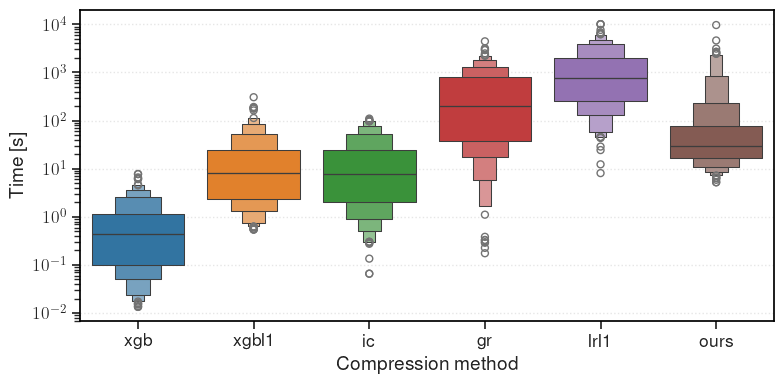

In [8]:
alltimes = {k: [] for k in methods}
for dname, df in dfs.items():
    for method in methods:
        alltimes[method] += list(df.loc[:, (method, "time")].values)

fig, ax = plt.subplots(figsize=(8, 4))

ax = sns.boxenplot(alltimes, ax=ax, zorder=1)
#ax = sns.boxplot(alltimes)
#ax = sns.violinplot(alltimes)
ax.set_yscale("log")
ax.set_ylabel("Time [s]")
ax.set_xlabel("Compression method")

ax.get_figure().tight_layout()
ax.get_figure().savefig("boxenplot.png", dpi=300)

dfstats = pd.concat([hullcounts,
                     #dfperf_avg_nleafs, dfperf_avg_mtest,
                     pd.Series({k: np.mean(x) for k, x in alltimes.items()}, name="mean_time"),
                     pd.Series({k: np.median(x) for k, x in alltimes.items()}, name="median_time")],
                    axis=1)
display(dfstats)

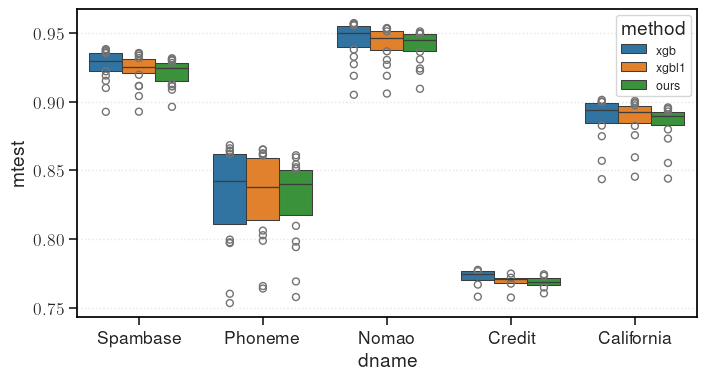

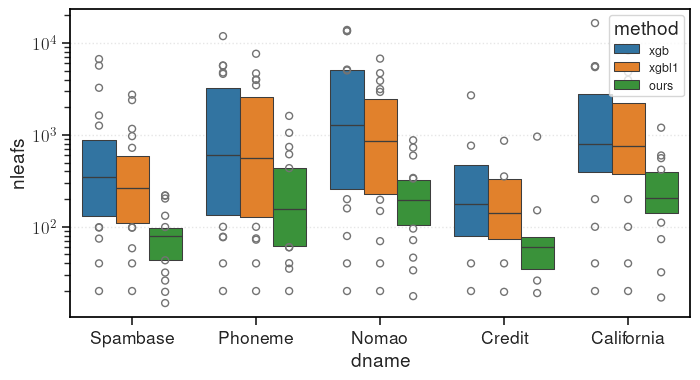

In [9]:
for col in ["mtest", "nleafs"]:
    alldname = []
    allmethod = []
    allmtest = []
    #for dname in dfs.keys():
    for dname in ["Spambase", "Phoneme", "Nomao", "Credit", "California"]:
        df = dfs[dname]
        for method in ["xgb", "xgbl1", "ours"]:
            vs = df.loc[:, (method, col)].values
            allmtest += list(vs)
            alldname += [dname] * len(vs)
            allmethod += [method] * len(vs)
    
    dfbut = pd.DataFrame({
        "dname": alldname,
        "method": allmethod,
        col: allmtest,
    })
    
    fig, ax = plt.subplots(figsize=(8, 4))
    if col == "nleafs":
        ax.set_yscale("log")
    #sns.violinplot(data=dfbut_acc, x="dname", y=col, hue="method",
    #               split=True, inner="quart", fill=False,
    #               palette={"xgb": "g", "ours": ".35"}, ax=ax)
    sns.boxenplot(data=dfbut, x="dname", y=col, hue="method")
    plt.show()

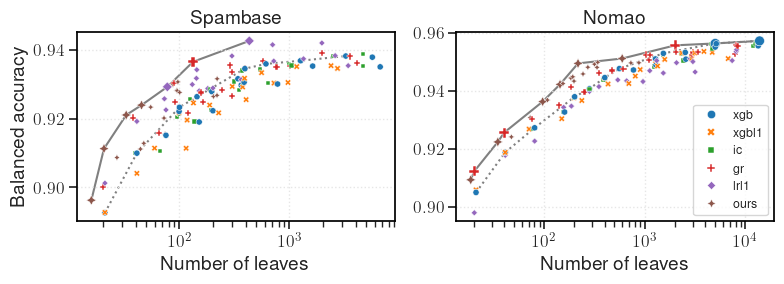

In [16]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(8, 3))

for ax, dname in zip((ax0, ax1), ("Spambase", "Nomao")):
    df = dfs[dname]
    ax.set_title(dname)
    allxs, allys, allcs, allms, frontxs, frontys, frontcs, frontms = analyze_hull(df)
    plot_curve(ax, allxs, allys, allcs, allms, frontxs, frontys, frontcs, frontms)

ax0.get_legend().remove()
ax1.set_ylabel("")

fig.tight_layout()
fig.savefig("frontiers.png", dpi=300)

# Latex

In [11]:
def highlight_max(x):
    nleafs = x.loc["nleafs", slice(None)]
    min_nleafs = (nleafs == nleafs[methods[1:]].max()).to_numpy()
    mtest = x.loc["mtest", slice(None)]
    max_mtest = (mtest == -1).to_numpy() # don't highlight anything
    max_mtest[0] = False # don't color xgb
    mask = np.concatenate([min_nleafs, max_mtest])
    return np.where(mask, "c:olor{OliveGreen};", None)

dfperf_str = (dfperf).style.format({("nleafs", "xgb"): '{:.0f}'}, precision=1).apply(highlight_max, axis=1)
dfperf_str = dfperf_str.to_latex(siunitx=True, multicol_align="c", hrules=True)
print(dfperf_str)

\begin{tabular}{lllllllllllll}
\toprule
{} & \multicolumn{6}{c}{nleafs} & \multicolumn{6}{c}{mtest} \\
{} & {xgb} & {xgbl1} & {ic} & {gr} & {lrl1} & {ours} & {xgb} & {xgbl1} & {ic} & {gr} & {lrl1} & {ours} \\
\midrule
CompasTwoYears & 289 & 2.6 & 1.2 & 1.4 & 2.2 & \color{OliveGreen} 5.1 & 67.2 & -0.1 & -0.1 & -0.3 & -0.5 & -0.4 \\
Vehicle & 453 & 1.3 & 1.5 & 1.2 & 1.2 & \color{OliveGreen} 3.0 & 93.7 & -0.8 & -0.6 & -0.2 & 0.5 & -1.5 \\
Spambase & 1120 & 1.5 & 1.1 & 1.3 & 1.4 & \color{OliveGreen} 7.9 & 92.7 & -0.3 & -0.1 & 0.2 & 0.4 & -0.5 \\
Phoneme & 2138 & 1.2 & 1.2 & 1.2 & 1.1 & \color{OliveGreen} 4.9 & 83.2 & -0.0 & -0.1 & 0.5 & 0.1 & -0.3 \\
Nomao & 3387 & 1.6 & 1.0 & 1.3 & 1.3 & \color{OliveGreen} 8.5 & 94.5 & -0.3 & -0.0 & 0.1 & -0.4 & -0.4 \\
Adult & 1955 & 3.0 & 1.2 & 1.5 & 1.3 & \color{OliveGreen} 3.3 & 76.3 & -0.0 & 0.1 & 1.2 & -0.9 & -0.1 \\
Ijcnn1 & 4162 & 1.3 & 1.0 & 1.2 & 1.1 & \color{OliveGreen} 3.1 & 91.5 & -0.2 & -0.0 & 1.1 & -0.0 & -0.0 \\
Mnist[2v4] & 321 & 1.4 & 1.

In [12]:
dfstats_str = (dfstats).style.format(precision=3)
dfstats_str = dfstats_str.to_latex(siunitx=False, multicol_align="c", hrules=True)
print(dfstats_str)

\begin{tabular}{lrrrr}
\toprule
 & count & wins & mean_time & median_time \\
\midrule
xgb & 12 & 0 & 0.986 & 0.451 \\
xgbl1 & 6 & 0 & 23.135 & 8.136 \\
ic & 9 & 0 & 19.868 & 7.691 \\
gr & 29 & 2 & 522.181 & 202.099 \\
lrl1 & 12 & 2 & 1575.130 & 782.632 \\
ours & 69 & 11 & 233.109 & 30.142 \\
\bottomrule
\end{tabular}

